STEP 1: IMPORTING THE LIBARIES NEEDED AND DATA

In [2]:
# Import the libaray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report



In [3]:

fifa = pd.read_csv("kl.csv", encoding='ISO-8859-1')
fifa.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


In [ ]:
fifa.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [ ]:
fifa['Position'].unique()

array(['RF', 'ST', 'LW', 'GK', 'RCM', 'LF', 'RS', 'RCB', 'LCM', 'CB',
       'LDM', 'CAM', 'CDM', 'LS', 'LCB', 'RM', 'LAM', 'LM', 'LB', 'RDM',
       'RW', 'CM', 'RB', 'RAM', 'CF', 'RWB', 'LWB', nan], dtype=object)

STEP 2: CLEANING THE DATA

In [ ]:
fifa.isnull().sum().sort_values(ascending=False).head(15)

Loaned From    16943
LWB             2085
LCM             2085
RS              2085
LW              2085
LF              2085
CF              2085
RF              2085
RW              2085
LAM             2085
CAM             2085
RAM             2085
LM              2085
CM              2085
LS              2085
dtype: int64

In [ ]:
#Removing columns that are redunant
fifa_cleaned = fifa.drop(columns=[
    'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Body Type',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Jersey Number',
    'Release Clause'
], errors='ignore')

print("Shape after dropping irrelevant columns:", fifa_cleaned.shape)


Shape after dropping irrelevant columns: (18207, 78)


Filing the missing numeric and catergorical values

In [ ]:
# Filling missing numeric values with the column mean
numeric_cols = fifa_cleaned.select_dtypes(include='number').columns
fifa_cleaned[numeric_cols] = fifa_cleaned[numeric_cols].fillna(fifa_cleaned[numeric_cols].mean())

# Filling missing categorical values with the most common entry
categorical_cols = fifa_cleaned.select_dtypes(include='object').columns
fifa_cleaned[categorical_cols] = fifa_cleaned[categorical_cols].fillna(fifa_cleaned[categorical_cols].mode().iloc[0])


In [ ]:
#Simplifying the positions into labels for the model
# Create Simplified_Role if it doesn't exist
if 'Simplified_Role' not in fifa_cleaned.columns:
    def simplify_role(pos):
        if pos in ['ST', 'CF', 'LW', 'RW', 'LF', 'RF']:
            return 'Attacker'
        elif pos in ['CM', 'CAM', 'CDM', 'RM', 'LM']:
            return 'Midfielder'
        elif pos in ['CB', 'LB', 'RB', 'LWB', 'RWB']:
            return 'Defender'
        else:
            return 'Other'
    fifa_cleaned['Simplified_Role'] = fifa_cleaned['Position'].apply(simplify_role)


Selecting the Features for Clustering

In [ ]:
# Use the dataframe where you created Simplified_Role
selected_features = [
    'Finishing', 'ShotPower', 'Acceleration', 'Dribbling',  # Attack
    'Interceptions', 'StandingTackle', 'Strength', 'Aggression',  # Defense
    'ShortPassing', 'Vision', 'BallControl', 'Reactions'  # Midfield
]

# Drop rows with missing values in selected columns
fifa_selected = fifa_cleaned[selected_features + ['Simplified_Role']].dropna()
fifa_selected.head()

,Finishing,ShotPower,Acceleration,Dribbling,Interceptions,StandingTackle,Strength,Aggression,ShortPassing,Vision,BallControl,Reactions,Simplified_Role
0,95.0,85.0,91.0,97.0,22.0,28.0,59.0,48.0,90.0,94.0,96.0,95.0,Attacker
1,94.0,95.0,89.0,88.0,29.0,31.0,79.0,63.0,81.0,82.0,94.0,96.0,Attacker
2,87.0,80.0,94.0,96.0,36.0,24.0,49.0,56.0,84.0,87.0,95.0,94.0,Attacker
3,13.0,31.0,57.0,18.0,30.0,21.0,64.0,38.0,50.0,68.0,42.0,90.0,Other
4,82.0,91.0,78.0,86.0,61.0,58.0,75.0,76.0,92.0,94.0,91.0,91.0,Other


FEATURE SCALING

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(fifa_selected[selected_features])


In [ ]:
#Applying K-means Clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
fifa_selected['Predicted_Role'] = kmeans.fit_predict(X_scaled)


Visualizing the Clusters of the k-Means

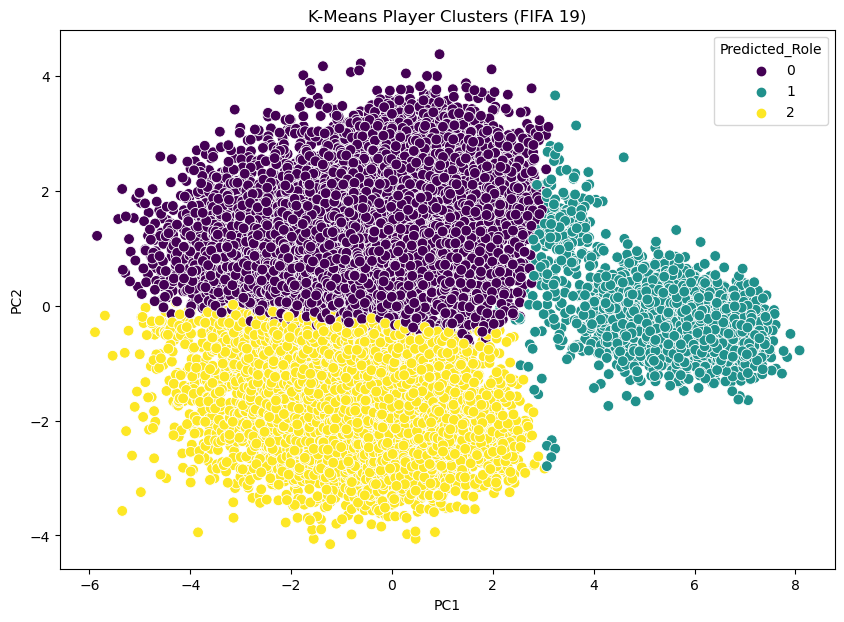

In [ ]:
# Visualalizing the clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
fifa_selected['PC1'] = X_pca[:, 0]
fifa_selected['PC2'] = X_pca[:, 1]

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=fifa_selected,
    x='PC1', y='PC2',
    hue='Predicted_Role',
    palette='viridis',
    s=60
)
plt.title('K-Means Player Clusters (FIFA 19)')
plt.show()


Evaluating the Model

In [ ]:
# Compare the majority label in each cluster
mapping = {}
for cluster in range(3):
    mode_label = fifa_selected[fifa_selected['Predicted_Role'] == cluster]['Simplified_Role'].mode()[0]
    mapping[cluster] = mode_label

# Map clusters to actual roles
fifa_selected['Predicted_Role_Mapped'] = fifa_selected['Predicted_Role'].map(mapping)


In [ ]:
#calculateing how close the predicted clusters are to the true roles.
silhouette = silhouette_score(X_scaled, kmeans.labels_)
f1 = f1_score(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'], average='weighted')
acc = accuracy_score(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'])

print(f"Silhouette Score: {silhouette:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"Accuracy: {acc:.3f}")


Silhouette Score: 0.277
F1 Score: 0.469
Accuracy: 0.523


3️⃣ Confusion Matrix (Safe Version)



🧩 Confusion Matrix:
[[   0  146 2910   12]
 [   0 4287   81  188]
 [   0 2320 3199    0]
 [   0 2333  689 2042]]

Detailed Report:
              precision    recall  f1-score   support

    Attacker       0.00      0.00      0.00      3068
    Defender       0.47      0.94      0.63      4556
  Midfielder       0.47      0.58      0.52      5519
       Other       0.91      0.40      0.56      5064

    accuracy                           0.52     18207
   macro avg       0.46      0.48      0.43     18207
weighted avg       0.51      0.52      0.47     18207



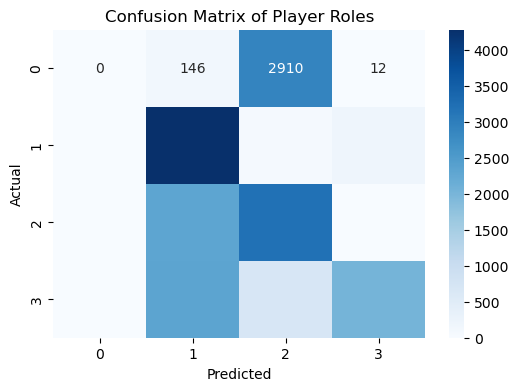

              precision    recall  f1-score   support

    Attacker       0.00      0.00      0.00      3068
    Defender       0.47      0.94      0.63      4556
  Midfielder       0.47      0.58      0.52      5519
       Other       0.91      0.40      0.56      5064

    accuracy                           0.52     18207
   macro avg       0.46      0.48      0.43     18207
weighted avg       0.51      0.52      0.47     18207



In [ ]:

if {'Simplified_Role', 'Predicted_Role_Mapped'}.issubset(fifa_selected.columns):
    cm = confusion_matrix(fifa_selected['Simplified_Role'], fifa_selected['Predicted_Role_Mapped'])
    print("\n🧩 Confusion Matrix:")
    print(cm)

    print("\nDetailed Report:")
    print(classification_report(
        fifa_selected['Simplified_Role'],
        fifa_selected['Predicted_Role_Mapped'],
        zero_division=0
    ))

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix of Player Roles')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
else:
    print("⚠️ Confusion matrix not displayed — required columns missing or empty.")


print(classification_report(
    fifa_selected['Simplified_Role'],
    fifa_selected['Predicted_Role_Mapped'],
    zero_division=0
))



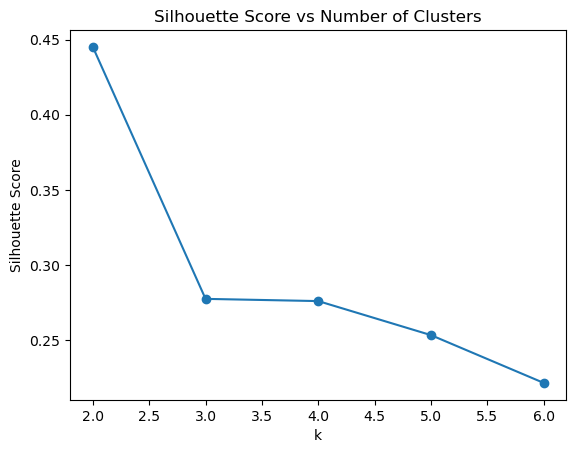

In [ ]:
#Finding the best k-value
scores = []
for k in range(2, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(range(2,7), scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()


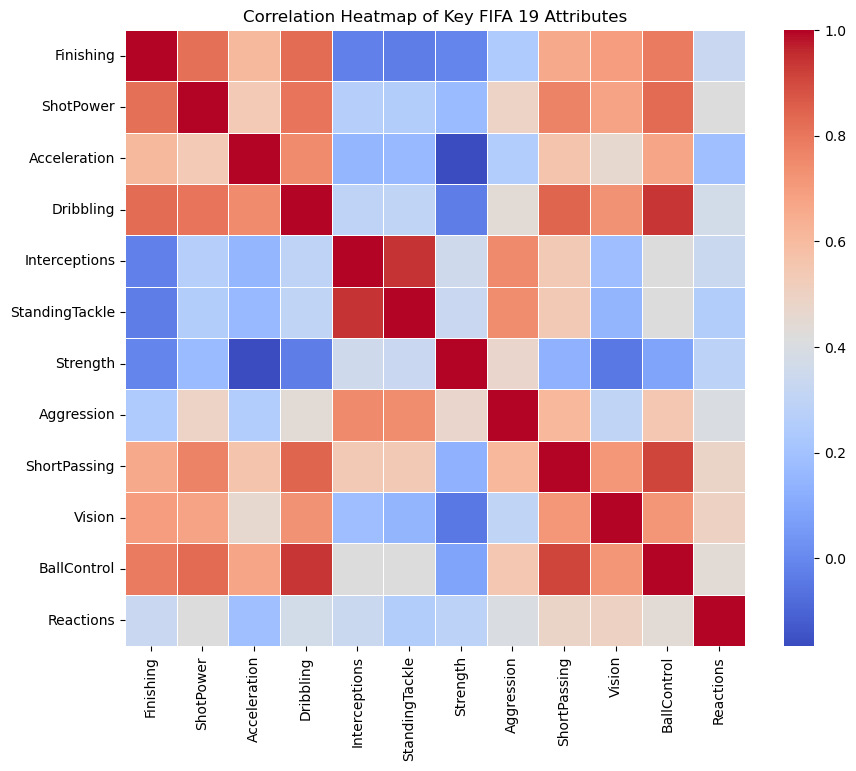

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(
    fifa_selected[selected_features].corr(),
    cmap='coolwarm',
    annot=False,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Key FIFA 19 Attributes')
plt.show()


In [ ]:
# First, check what's in these columns
features = ['Overall', 'Potential', 'Value', 'Wage']

print("Data types and sample values:")
for feature in features:
    if feature in fifa.columns:
        print(f"\n{feature}:")
        print(f"  Data type: {fifa[feature].dtype}")
        print(f"  Sample values: {fifa[feature].head(3).tolist()}")
    else:
        print(f"\n{feature}: Column not found!")

# Then clean and plot based on what you find

Data types and sample values:

Overall:
  Data type: float64
  Sample values: [94.0, 94.0, 92.0]

Potential:
  Data type: int64
  Sample values: [94, 94, 93]

Value:
  Data type: object
  Sample values: ['\x80110.5M', '\x8077M', '\x80118.5M']

Wage:
  Data type: object
  Sample values: ['\x80565K', '\x80405K', '\x80290K']


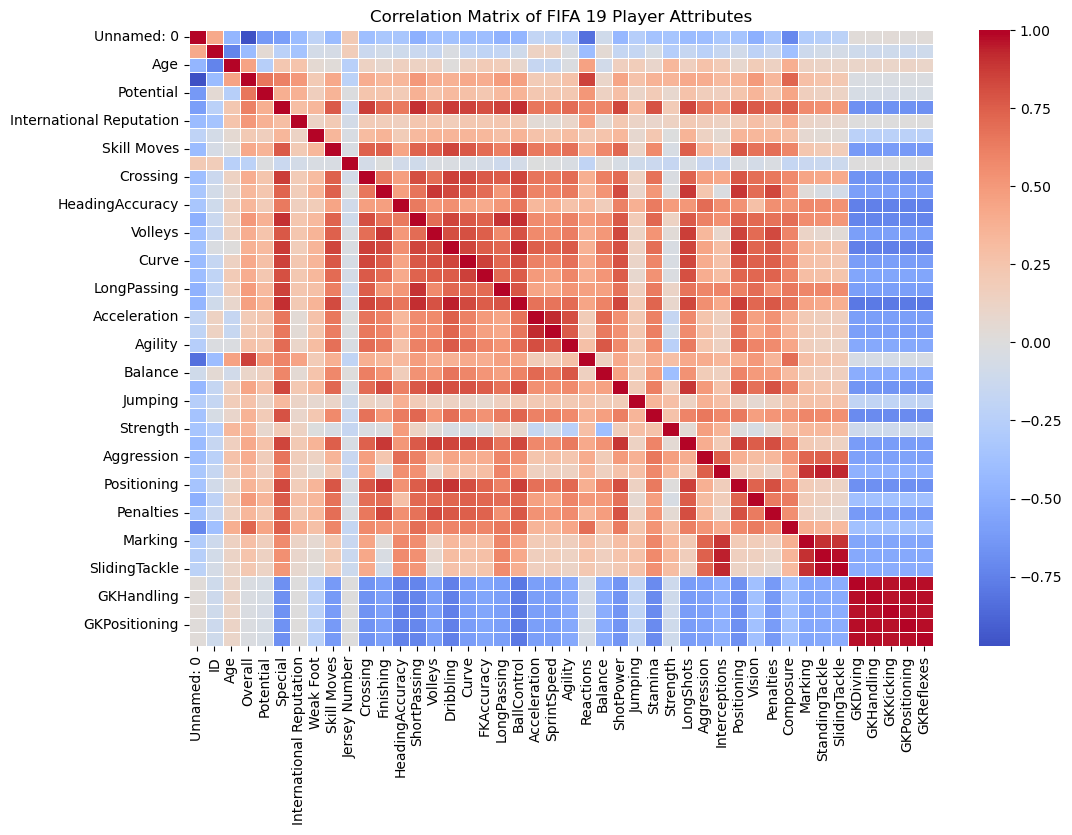

In [ ]:
numeric_features = fifa.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of FIFA 19 Player Attributes')
plt.show()


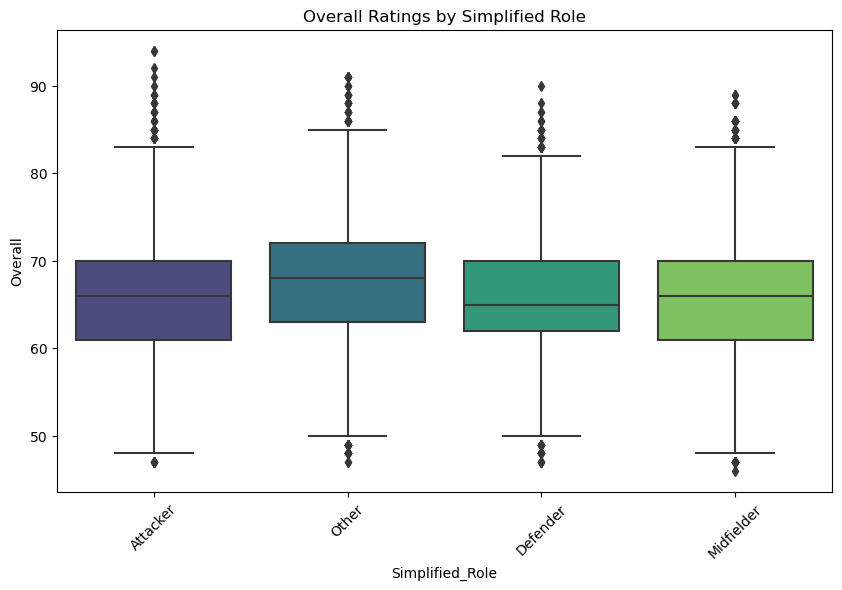

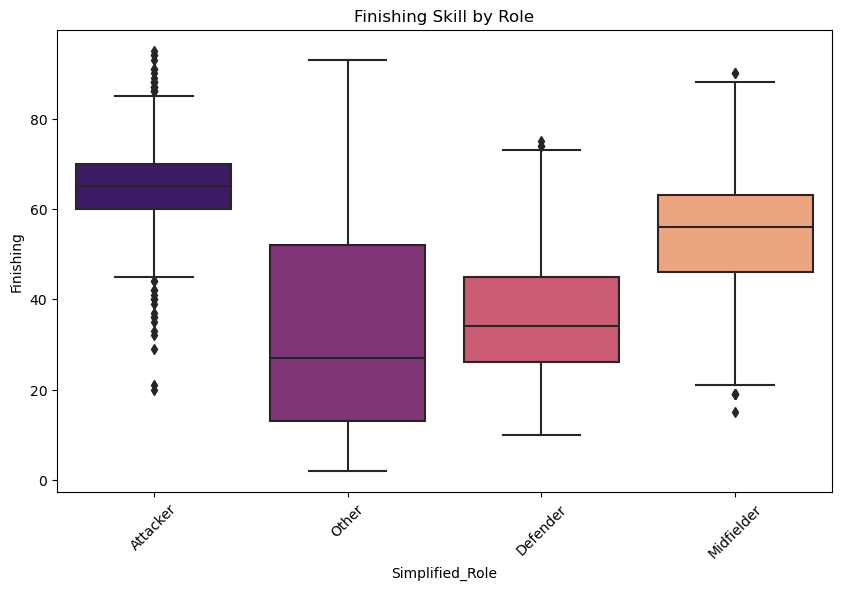

In [ ]:
key_attributes = ['Finishing', 'ShortPassing', 'Dribbling', 'Defending', 'Physical']

plt.figure(figsize=(10,6))
sns.boxplot(data=fifa_cleaned, x='Simplified_Role', y='Overall', palette='viridis')
plt.title('Overall Ratings by Simplified Role')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=fifa_cleaned, x='Simplified_Role', y='Finishing', palette='magma')
plt.title('Finishing Skill by Role')
plt.xticks(rotation=45)
plt.show()

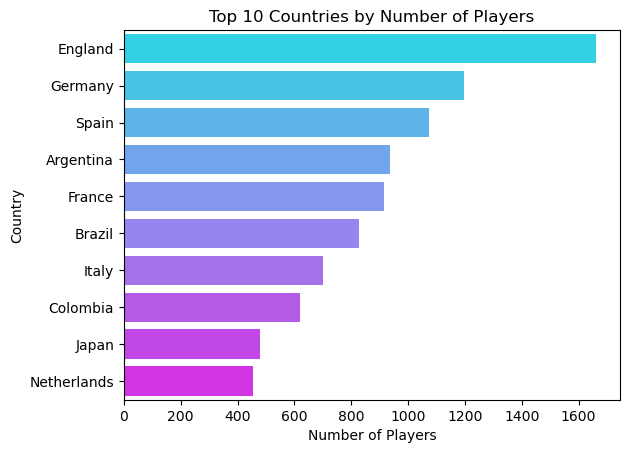

In [ ]:
top_countries = fifa['Nationality'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='cool')
plt.title('Top 10 Countries by Number of Players')
plt.xlabel('Number of Players')
plt.ylabel('Country')
plt.show()


## Random Forest Model

In [2]:
#Importing the Libaries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Importing the Dataset
df= pd.read_csv("kl.csv", encoding='ISO-8859-1')

In [4]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


In [5]:
#Removing columns that are redunant
df_cleaned = df.drop(columns=[
    'ID', 'Photo', 'Flag', 'Club Logo', 'Real Face', 'Body Type',
    'Joined', 'Loaned From', 'Contract Valid Until', 'Jersey Number',
    'Release Clause'
], errors='ignore')

print("Shape after dropping irrelevant columns:", df_cleaned.shape)


Shape after dropping irrelevant columns: (18207, 78)


In [6]:
# Filling missing numeric values with the column mean
numeric_cols = df_cleaned.select_dtypes(include='number').columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(df_cleaned[numeric_cols].mean())

# Filling missing categorical values with the most common entry
categorical_cols = df_cleaned.select_dtypes(include='object').columns
df_cleaned[categorical_cols] = df_cleaned[categorical_cols].fillna(df_cleaned[categorical_cols].mode().iloc[0])


In [7]:
def simplify_role(pos):
    if pos in ['CB', 'LB', 'RB', 'LCB', 'RCB', 'LWB', 'RWB']:
        return 'Defender'
    elif pos in ['CM', 'CDM', 'CAM', 'LM', 'RM', 'LDM', 'RDM', 'LCM', 'RCM']:
        return 'Midfielder'
    else:
        return 'Attacker'
        
df_cleaned['Simplified_Role'] = df_cleaned['Position'].apply(simplify_role)


In [8]:
features = [
    'Overall', 'Potential', 'Crossing', 'Finishing', 'HeadingAccuracy',
    'ShortPassing', 'Dribbling', 'LongPassing', 'BallControl', 
    'Acceleration', 'SprintSpeed', 'Agility', 'Stamina', 'Strength',
    'Interceptions', 'Positioning', 'Marking', 'StandingTackle', 'SlidingTackle'
]

## feature engineering

In [9]:
df_cleaned['Height_cm'] = df['Height'].str.extract(r'(\d+)').astype(float) * 2.54  # convert from feet/inches
df_cleaned['Weight_kg'] = df['Weight'].str.replace('lbs', '').astype(float) * 0.453592
df_cleaned['BMI'] = df_cleaned['Weight_kg'] / (df_cleaned['Height_cm']/100)**2


In [10]:
y = df_cleaned['Simplified_Role']


In [11]:
if 'BMI' in df_cleaned.columns:
    X = df_cleaned[features + ['BMI']]
else:

    X = df_cleaned[features]
   
y = df_cleaned['Simplified_Role']

## Spliting the data and training the model

In [12]:
# Now split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Checking for the Meterics

In [13]:
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8786381109280615

Classification Report:
               precision    recall  f1-score   support

    Attacker       0.91      0.86      0.88      1130
    Defender       0.90      0.94      0.92      1113
  Midfielder       0.84      0.85      0.84      1399

    accuracy                           0.88      3642
   macro avg       0.88      0.88      0.88      3642
weighted avg       0.88      0.88      0.88      3642


Confusion Matrix:
 [[ 967    3  160]
 [   0 1042   71]
 [  94  114 1191]]


## Visualiations for the Random Forest

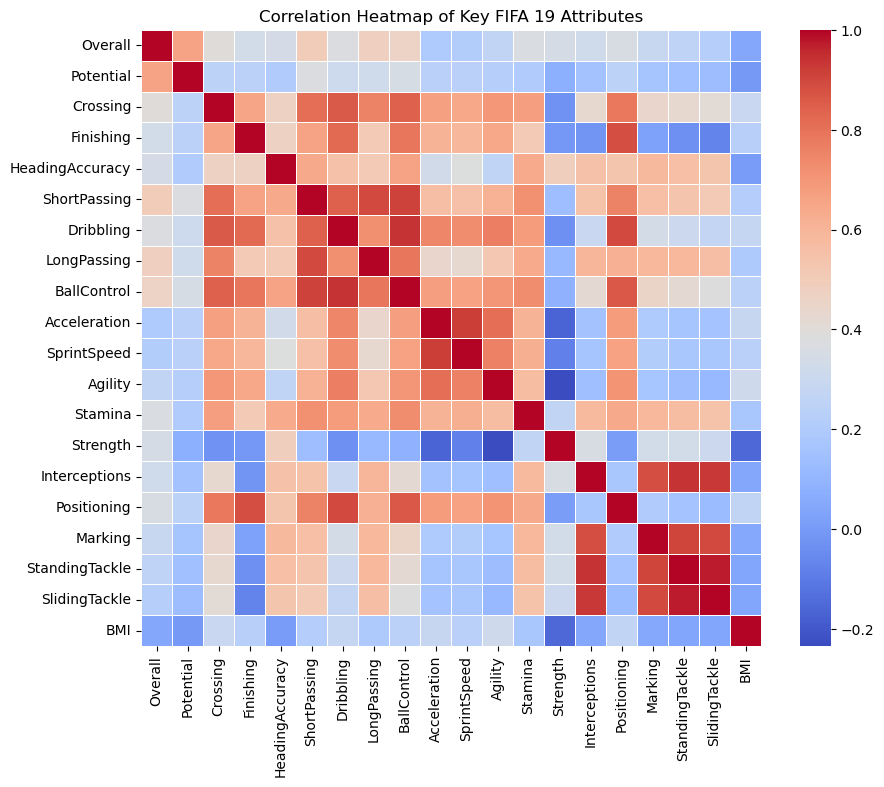

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(
    df_cleaned[features + ['BMI']].corr(),
    cmap='coolwarm',
    annot=False,
    linewidths=0.5
)
plt.title('Correlation Heatmap of Key FIFA 19 Attributes')
plt.show()


C:\Users\enobo\AppData\Local\Temp\ipykernel_13036\3964901186.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Overall', palette='viridis')


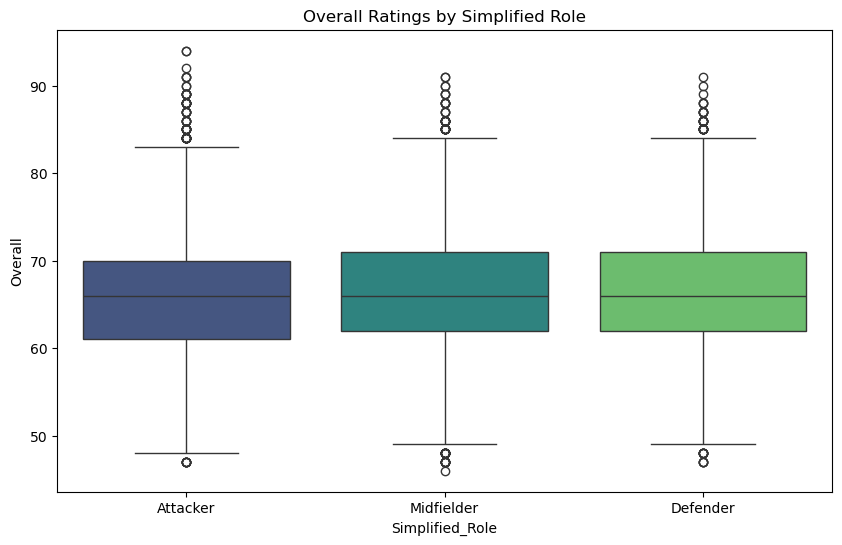

C:\Users\enobo\AppData\Local\Temp\ipykernel_13036\3964901186.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Finishing', palette='magma')


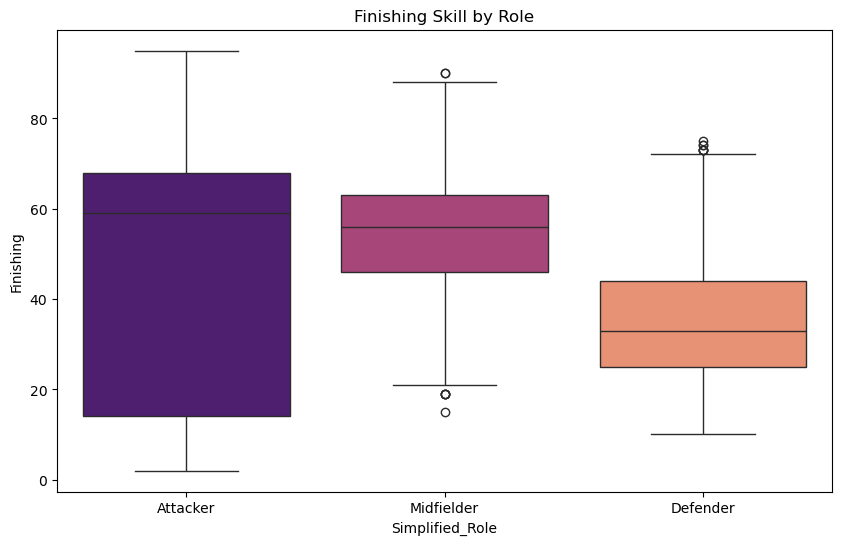

In [15]:
key_attributes = ['Finishing', 'ShortPassing', 'Dribbling', 'Defending', 'Physical']

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Overall', palette='viridis')
plt.title('Overall Ratings by Simplified Role')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cleaned, x='Simplified_Role', y='Finishing', palette='magma')
plt.title('Finishing Skill by Role')
plt.show()


## SHAP AND LIME

In [16]:
# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')


In [17]:
# Create new features
df['PhysicalAbility'] = df[['Strength', 'Stamina', 'Jumping']].mean(axis=1)
df['TechnicalSkill'] = df[['BallControl', 'Dribbling', 'ShortPassing', 'Finishing']].mean(axis=1)
df['MentalAbility'] = df[['Vision', 'Composure', 'Reactions', 'Positioning']].mean(axis=1)


In [18]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

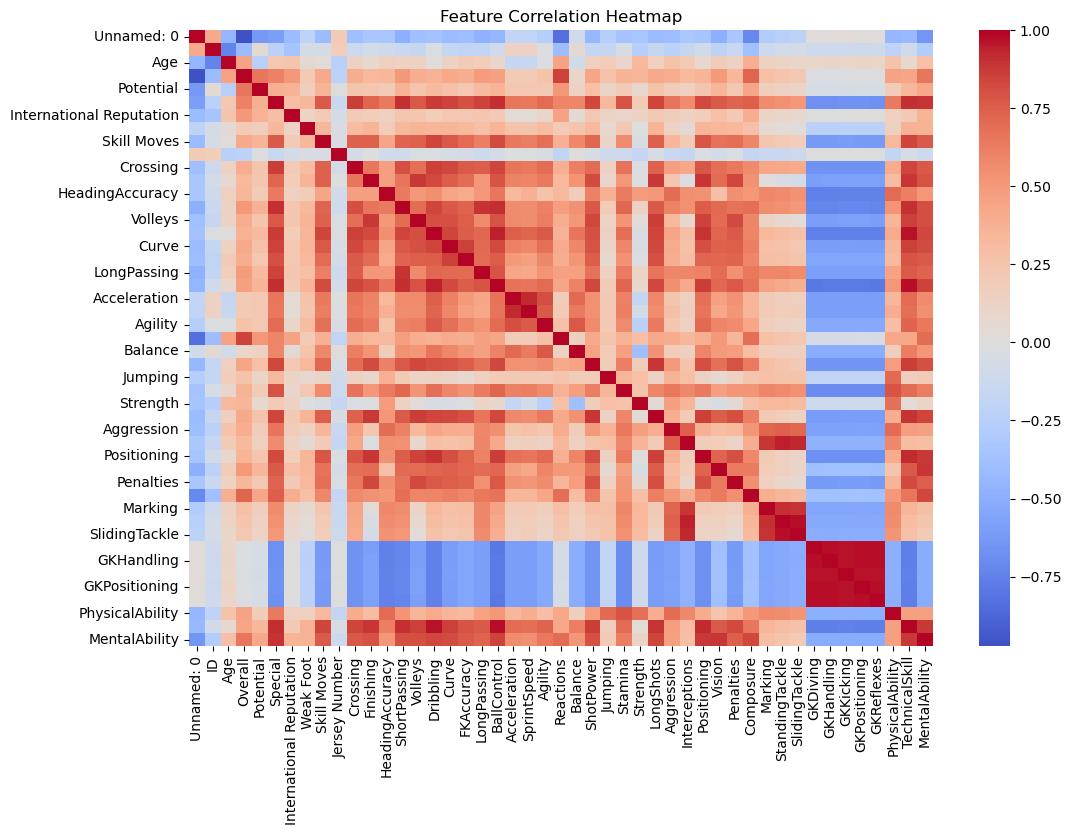

In [19]:
# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

# Drop highly correlated features (r > 0.9)
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df.drop(columns=to_drop, inplace=True)


In [21]:
# Fill missing numerical and categorical values
df = df.fillna(df.median(numeric_only=True))
for col in df.select_dtypes(include='object').columns:
    df[col].fillna(df[col].mode()[0], inplace=True)


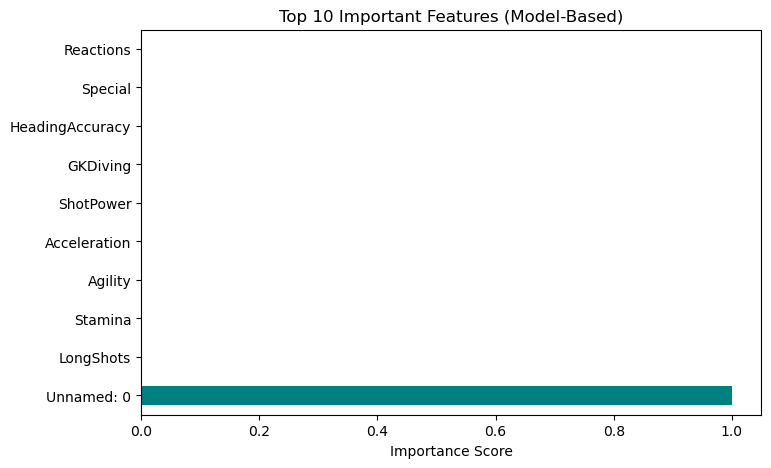

In [22]:
from sklearn.ensemble import RandomForestRegressor
# Predicting 'Overall' rating
X = df.select_dtypes(include=['int64', 'float64']).drop(columns=['Overall'])
y = df['Overall']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top_features = importances.head(10)

plt.figure(figsize=(8, 5))
top_features.plot(kind='barh', color='teal')
plt.title('Top 10 Important Features (Model-Based)')
plt.xlabel('Importance Score')
plt.show()


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Decision Tree": DecisionTreeRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    scores = cross_val_score(model,y, cv=5, scoring='r2')
    results[name] = scores.mean()

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'R² Score'])
results_df


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\enobo\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 886, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "C:\Users\enobo\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: LinearRegression.fit() missing 1 required positional argument: 'y'


In [25]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2')
grid.fit(X_train_a, y_train_a)

print("Best Params:", grid.best_params_)
print("Best R² Score:", grid.best_score_)


NameError: name 'X_train_a' is not defined

In [26]:
import shap

# Train best model
best_model = grid.best_estimator_
best_model.fit(X_train_a, y_train_a)

# Use SHAP
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_a)

# SHAP summary plot
shap.summary_plot(shap_values, X_test_a, plot_type="bar", max_display=10)


AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [ ]:
shap.summary_plot(shap_values, X_test_a)


In [27]:
plt.scatter(y_test_a, best_model.predict(X_test_a), alpha=0.6)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Actual vs Predicted Player Ratings")
plt.show()


NameError: name 'y_test_a' is not defined

In [28]:
feat_importances = pd.Series(best_model.feature_importances_, index=X_after.columns)
top10 = feat_importances.nlargest(10)
top10.plot(kind='barh', color='goldenrod')
plt.title("Top 10 Most Important Features (Random Forest)")
plt.show()


NameError: name 'best_model' is not defined